# EXERCISE 5

## Assessing the distribution of schools in the Helsinki region

##### Different areas and neighbourhoods in the Helsinki region have different levels of wealth, and investment by the administration is not necessarily proportional across the board. Some neighbourhoods might see more funds allocated to them while others might suffer from more administrative neglect. One area where this could be seen is the access to educational facilities such as schools in different neighbourhoods. Neglected neighbourhoods are expected to have less schools on a per capita basis than other neighbourhoods. In this exercise I will try to map on a population grid, and my questions will be the following:

1.Which areas of Helsinki have the worst access to education?

2.Are there differences between the access to primary and secondary school?

3.Is the coverage of special schools enough?

4.How many kids and teenagers live in the are there in the influence area of each school?

In [28]:
# Importing some important modules

import pandas as pd
import geopandas as gpd
import requests
#import os
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import CRS
import geojson
from shapely.ops import nearest_points
import seaborn as sns

In [2]:
#os.getcwd() 
#os.chdir("/home/jovyan/work/autogis/exercises/exercise-5-NicoOrdax/")

In [3]:
#os.getcwd()

##### First we import the data on the locations of our schools. The data come from Paituli (https://avaa.tdata.fi/web/paituli/latauspalvelu) and consist of point data in a shapefile with every school being one point. There might also be additional information, which we will have to explore. The file contains information on all the finnish schools so we might have to clip it to the Helsinki region.

In [71]:
# Reading data on the schools
fp = r"data/oppilaitokset_2017.shp"
schools = gpd.read_file(fp)

# Exploring the data
print(len(schools))
print(schools.head())
print(schools["oltyp_nimi"].unique())

2812
                          onimi oltyp   oltyp_nimi  \
0              Aapiskujan koulu    11  Peruskoulut   
1            Aarnivalkean koulu    11  Peruskoulut   
2     Adv.kirkon Kopun ala-aste    11  Peruskoulut   
3  Adv.kirkon Siikasalmen koulu    11  Peruskoulut   
4                   Ahjon koulu    11  Peruskoulut   

                         geometry  
0  POINT (340457.000 7007583.000)  
1  POINT (377549.000 6674307.000)  
2  POINT (350507.000 6692919.000)  
3  POINT (621465.000 6933971.000)  
4  POINT (397507.000 6697358.000)  
['Peruskoulut' 'Peruskouluasteen erityiskoulut' 'Lukiot'
 'Perus- ja lukioasteen koulut']


##### Before doing anything we want to check the CRS of the layer and do any necessary adjustments.

In [72]:
# First I check the type of the CRS object
print(type(schools.crs))

# Now I want to check the EPSG code and transform it so that I can work more easily 
print(schools.crs)
schools.crs = schools.crs.to_epsg()

# Checking that it worked
print(schools.crs)
print(type(schools.crs))

<class 'pyproj.crs.crs.CRS'>
PROJCS["ETRS89_TM35FIN_E_N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",27],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
epsg:3067
<class 'pyproj.crs.crs.CRS'>


##### As we see the dataset contains data on the name of our schools, the location and the type of schools. There are 4 types of schools in the dataset. Primary schools, secondary schools, primary and secondary schools and finally special schools. The CRS of the data set is ETRS89_TM35_FIN_E_N, which should correspond to epsg 3067. Since we're only interested in the Helsinki region, we can clip the layer a bit to reduce it's size, it might help when doing operations and plotting with it.

In [73]:
# Creating a rectangle that more or less contains Helsinki to be use as a mask
clip = Polygon([(365000, 6669000), (402000,6669000), (402000, 6695000), (365000, 6695000)])

# Clipping according to the layer, resetting the index and selecting the columns we want
schools  = schools[schools["geometry"].within(clip)]
schools.reset_index(inplace=True)
schools = schools[["oltyp_nimi", "geometry"]]

# Checking if the data look good
print(schools.head())
print(len(schools))

                     oltyp_nimi                        geometry
0                   Peruskoulut  POINT (377549.000 6674307.000)
1                   Peruskoulut  POINT (386387.000 6674122.000)
2                        Lukiot  POINT (383573.000 6677849.000)
3  Perus- ja lukioasteen koulut  POINT (381346.000 6680644.000)
4                   Peruskoulut  POINT (387743.000 6675892.000)
318


In [74]:
# Taking a look at the schools in the Helsinki area:

print("There are", len(schools[schools["oltyp_nimi"]=="Peruskoulut"]), "primary schools")
print("There are", len(schools[schools["oltyp_nimi"]=="Lukiot"]), "secondary schools")
print("There are", len(schools[schools["oltyp_nimi"]=="Perus- ja lukioasteen koulut"]), "primary+secondary schools")
print("There are", len(schools[schools["oltyp_nimi"]=="Peruskouluasteen erityiskoulut"]), "special primary schools")

There are 249 primary schools
There are 38 secondary schools
There are 21 primary+secondary schools
There are 10 special primary schools


##### Now we read the population grid data for Helsinki. We can follow the same procedure as in Lesson 3: Spatial Join. The data should be in EPSG 3789, and we will have to set it manually. This data contains information on the number of inhabitats in every grid square by age class. From here on we will assume that the age class 0-9 corresponds to kids who go to primary school and that the age class 10-19 corresponds to kids who go to secondary school. This is probably not entirely correct, but for the purpose of this exercise it will have to do (and I have no idea how the finnish education system works).

In [75]:
# First we specify from which web address we want to download the data, and store the file for more convenience
url = 'https://kartta.hsy.fi/geoserver/wfs'
# Then we have to describe which features and conditions we want our data to fulfill
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')
# Now that we have the url and parameters for downloading the data we can proceed using the requests.get() function
r = requests.get(url, params = params)
# We have downloaded the data into a JSON object called "r"

# Extracting the information from the JSON file "r" into a gpd.DataFrame which is easier to manipulate
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

# Setting the CRS of the pop layer (in this case EPSG:3857)
pop.crs = "EPSG:3879" 
print(pop.crs)

# Selecting and renaming our columns of interest
pop = pop[["geometry", "ika0_9", "ika10_19"]]
pop.rename(columns={"ika0_9":"kids", "ika10_19":"teenagers"}, inplace=True)

# Checking that "pop" looks good
pop.head()

EPSG:3879


,geometry,kids,teenagers
0,MULTIPOLYGON Z (((25476499.999 6674248.999 0.0...,11,23
1,MULTIPOLYGON Z (((25476749.997 6674498.998 0.0...,35,24
2,MULTIPOLYGON Z (((25476999.994 6675749.004 0.0...,46,24
3,MULTIPOLYGON Z (((25476999.994 6675499.004 0.0...,52,37
4,MULTIPOLYGON Z (((25476999.994 6675249.005 0.0...,64,32


##### Now let's do a little sanity check and plot our population grid together with the schools point layer to see if the data match spatially. I'm going to plot them with a base map below, so I need to reproject them.

epsg:3857 epsg:3857


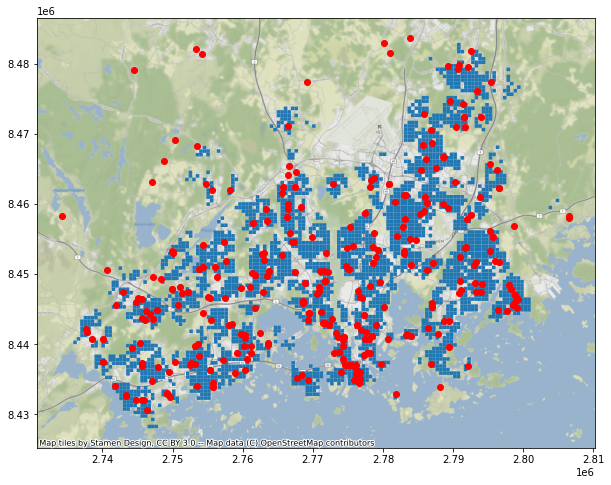

In [76]:
# Reprojecting the two datasets to EPSG:3857 to add basemap
schools = schools.to_crs(3857)
pop = pop.to_crs(3857)
# Let's check if it worked
print(schools.crs, pop.crs)

# Creating the plot to see if our layers work well
fig, ax = plt.subplots(figsize=(10,8))
pop.plot(ax=ax)
schools.plot(ax = ax, color="red")
ctx.add_basemap(ax)

##### The data seem to be ok, now let's calculate the distance from each grid to the closest school.

In [77]:
# First we split the dataset of schools according whether they are primary, secondary or special schools

# Primary schools also include primary + secondary schools
primary = schools[(schools["oltyp_nimi"]=="Peruskoulut")| (schools["oltyp_nimi"]=="Perus- ja lukioasteen koulut")]
primary.reset_index(inplace=True)

# Secondary schools also include primary + secondary schools
secondary = schools[(schools["oltyp_nimi"]=="Lukiot") | (schools["oltyp_nimi"]=="Perus- ja lukioasteen koulut")]
secondary.reset_index(inplace=True)

# Special schools
special = schools[schools["oltyp_nimi"]=="Peruskouluasteen erityiskoulut"]
special.reset_index(inplace=True)

# Creating three new empty columns. They will store the info on the nearest school of each type for the grid cell
pop["closest_primary"] = 0
pop["closest_secondary"] = 0
pop["closest_special"] = 0

# Creating a new empty column for the closest school independently of it's type
pop["closest_school"] = 0

# Looping over the grid cells to determine the closest of each school types using the nearest_points() function
# We need to convert the geometry column of our three datasets into MultiPoint objects for the nearest_points() function
for i in range(len(pop)):
    pop.loc[i, "closest_primary"] = nearest_points(pop.iloc[i, 0], MultiPoint(primary["geometry"]))[1]
    pop.loc[i, "closest_secondary"] = nearest_points(pop.iloc[i,0], MultiPoint(secondary["geometry"]))[1]
    pop.loc[i, "closest_special"] = nearest_points(pop.iloc[i,0], MultiPoint(special["geometry"]))[1]
    # Now for the closest school independently of it's type
    pop.loc[i, "closest_school"] = nearest_points(pop.iloc[i, 0], MultiPoint(schools["geometry"]))[1]
 
# Checking the output
pop.head()

,geometry,kids,teenagers,closest_primary,closest_secondary,closest_special,closest_school
0,MULTIPOLYGON Z (((2735848.290 8440015.529 0.00...,11,23,POINT (2737804.642438589 8441692.351310786),POINT (2737804.642438589 8441692.351310786),POINT (2743388.877899066 8432683.54683093),POINT (2737804.642438589 8441692.351310786)
1,MULTIPOLYGON Z (((2736346.567 8440521.047 0.00...,35,24,POINT (2737804.642438589 8441692.351310786),POINT (2737804.642438589 8441692.351310786),POINT (2743388.877899066 8432683.54683093),POINT (2737804.642438589 8441692.351310786)
2,MULTIPOLYGON Z (((2736832.315 8443036.322 0.00...,46,24,POINT (2737596.747061064 8442217.798165569),POINT (2737804.642438589 8441692.351310786),POINT (2743388.877899066 8432683.54683093),POINT (2737596.747061064 8442217.798165569)
3,MULTIPOLYGON Z (((2736835.465 8442533.836 0.00...,52,37,POINT (2737596.747061064 8442217.798165569),POINT (2737804.642438589 8441692.351310786),POINT (2743388.877899066 8432683.54683093),POINT (2737596.747061064 8442217.798165569)
4,MULTIPOLYGON Z (((2736838.614 8442031.385 0.00...,64,32,POINT (2737596.747061064 8442217.798165569),POINT (2737804.642438589 8441692.351310786),POINT (2743388.877899066 8432683.54683093),POINT (2737596.747061064 8442217.798165569)


##### Now that we know which are the closest schools to each grid we can calculate the distance of each grid to the closest schools of each type

In [78]:
# Creating empty columns to store the distances to each school type
pop["dist_sc"] = 0
pop["dist_pr"] = 0
pop["dist_se"] = 0
pop["dist_sp"] = 0

# Looping over the rows to calculate the distance from each grid cell to the closest school of each type
for i in range(len(pop)):
    pop.loc[i, "dist_sc"] = pop.loc[i, "geometry"].distance(pop.loc[i, "closest_school"])
    pop.loc[i, "dist_pr"] = pop.loc[i, "geometry"].distance(pop.loc[i, "closest_primary"])
    pop.loc[i, "dist_se"] = pop.loc[i, "geometry"].distance(pop.loc[i, "closest_secondary"])
    pop.loc[i, "dist_sp"] = pop.loc[i, "geometry"].distance(pop.loc[i, "closest_special"])
    
# Checking the data
pop.head()

,geometry,kids,teenagers,closest_primary,closest_secondary,closest_special,closest_school,dist_sc,dist_pr,dist_se,dist_sp
0,MULTIPOLYGON Z (((2735848.290 8440015.529 0.00...,11,23,POINT (2737804.642438589 8441692.351310786),POINT (2737804.642438589 8441692.351310786),POINT (2743388.877899066 8432683.54683093),POINT (2737804.642438589 8441692.351310786),1870.277943,1870.277943,1870.277943,10166.331578
1,MULTIPOLYGON Z (((2736346.567 8440521.047 0.00...,35,24,POINT (2737804.642438589 8441692.351310786),POINT (2737804.642438589 8441692.351310786),POINT (2743388.877899066 8432683.54683093),POINT (2737804.642438589 8441692.351310786),1168.055932,1168.055932,1168.055932,10210.700809
2,MULTIPOLYGON Z (((2736832.315 8443036.322 0.00...,46,24,POINT (2737596.747061064 8442217.798165569),POINT (2737804.642438589 8441692.351310786),POINT (2743388.877899066 8432683.54683093),POINT (2737596.747061064 8442217.798165569),862.650712,862.650712,1426.958241,11996.104851
3,MULTIPOLYGON Z (((2736835.465 8442533.836 0.00...,52,37,POINT (2737596.747061064 8442217.798165569),POINT (2737804.642438589 8441692.351310786),POINT (2743388.877899066 8432683.54683093),POINT (2737596.747061064 8442217.798165569),411.441191,411.441191,965.387372,11563.472862
4,MULTIPOLYGON Z (((2736838.614 8442031.385 0.00...,64,32,POINT (2737596.747061064 8442217.798165569),POINT (2737804.642438589 8441692.351310786),POINT (2743388.877899066 8432683.54683093),POINT (2737596.747061064 8442217.798165569),257.651613,257.651613,576.856158,11136.737685


#### Now we can circle back to some of our initial questions

##### 1.Which areas of Helsinki have the worst access to education?

We can plot the distance of the closest school in general for each grid cell and check which areas have the lowest values:

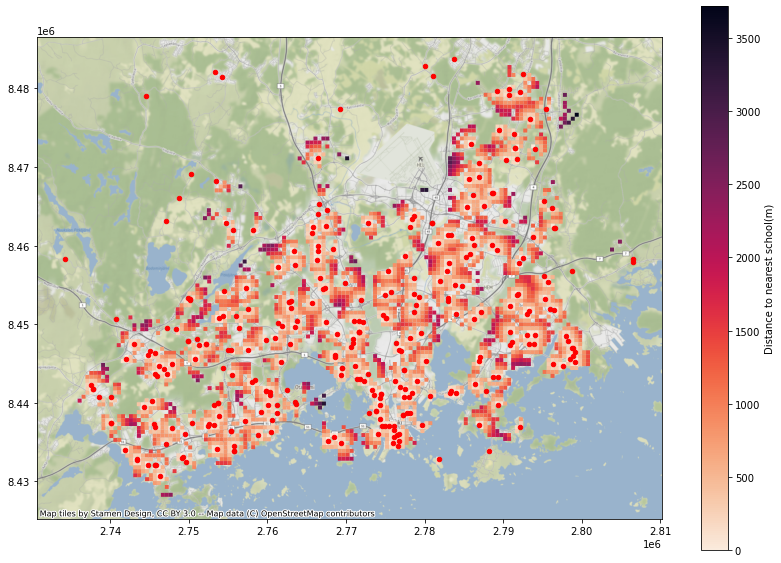

In [95]:
# Creating the figure
fig, ax = plt.subplots(figsize=(14,10)) 
# Plotting the population grid with darker red values the farther away the nearest school is
# Using a reddish colour palette which shows relatively well (especially the darker colours)
# Also adding a legend
pop.plot(ax=ax, 
         column="dist_sc", 
         cmap=sns.color_palette("rocket_r", as_cmap=True), 
         legend=True,
         legend_kwds={"label":"Distance to nearest school(m)"})
# Adding the schools as red points
schools.plot(ax = ax, color="red", markersize=20) 
# Adding a basemap to facilitate identifying the areas of the map
ctx.add_basemap(ax)

We see that most areas in Helsinki seem to be within 1km of the nearest school, which should be adequate enough. Nevertheless there are still some areas where the nearest school is quite far away. These areas seem to be spread mostly around the ring of E-Helsinki/Vantaa/N-Espoo, which if I recall correctly, tend to be the somewhat poorer areas. One possible interpretation of this map is that, although in general schools cover the Helsinki metropolitan region quite effectively, some more investment in schools could be made in the peripherical areas of the metropolitan region.

##### 2. Are there differences between the access to primary and secondary school?

We can make a plot of the distance to primary schools and another of the distance to secondary schools side by side.

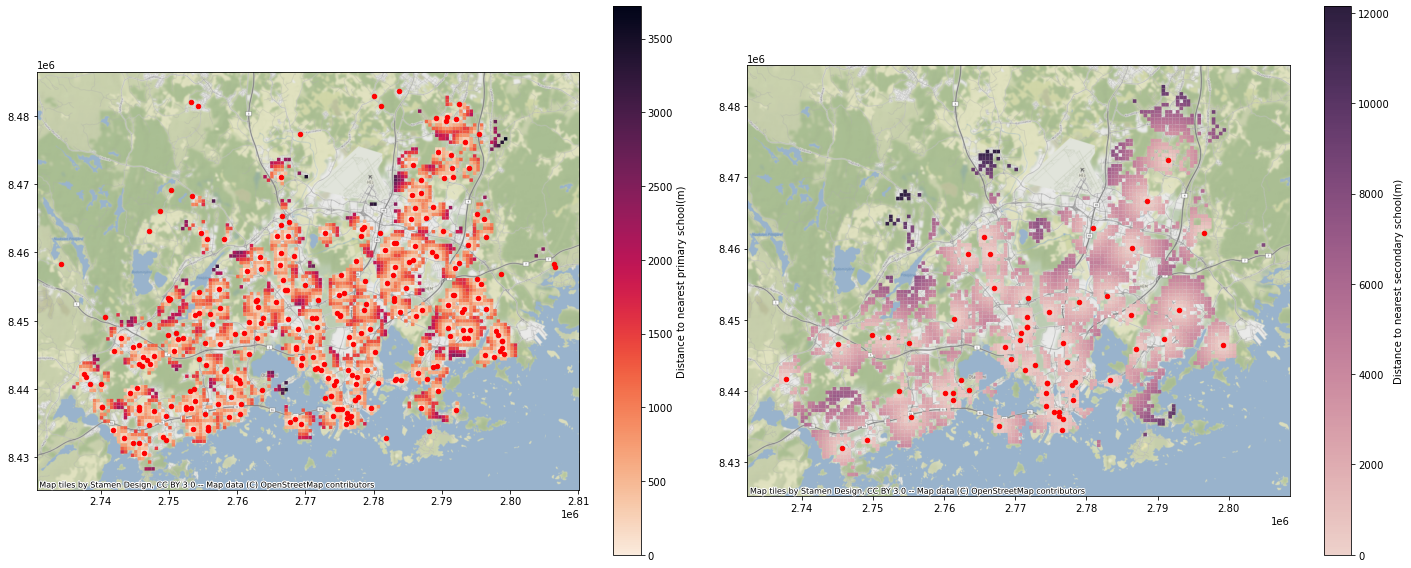

In [112]:
# Creating the figure with two subplots
fig, ax = plt.subplots(ncols=2, figsize=(20,8)) 

# Plotting the population grid with darker red values the farther away the nearest primary school is
# Using a reddish colour palette which shows relatively well (especially the darker colours)
# Also adding a legend
pop.plot(ax=ax[0], 
         column="dist_pr", 
         cmap=sns.color_palette("rocket_r", as_cmap=True), 
         legend=True,
         legend_kwds={"label":"Distance to nearest primary school(m)"})
# Adding the schools as red points
primary.plot(ax = ax[0], color="red", markersize=20) 
# Adding a basemap to facilitate identifying the areas of the map
ctx.add_basemap(ax[0])

# Repeating for secondary schools
pop.plot(ax=ax[1], 
         column="dist_se", 
         cmap=sns.cubehelix_palette(as_cmap=True), 
         legend=True,
         legend_kwds={"label":"Distance to nearest secondary school(m)"})
# Adding the schools as red points
secondary.plot(ax = ax[1], color="red", markersize=20) 
# Adding a basemap to facilitate identifying the areas of the map
ctx.add_basemap(ax[1])

plt.tight_layout()

As we can see the lack of secondary schools is mostly felt at the edge of the metropolitan area, especially in northern Vantaa and Espoo, while primary schools cover the whole area quite effectively in comparison. We have to be careful as the scales of the legends are not equal (the main reason why I used different colour palettes). The highest distance to the nearest high schools can be up to 12km while it never surpasses 4km in primary schools.

##### 3. Is the coverage of special schools enough?

We can repeat the procedure of the two previous questions. Not very original, but it gets the job done

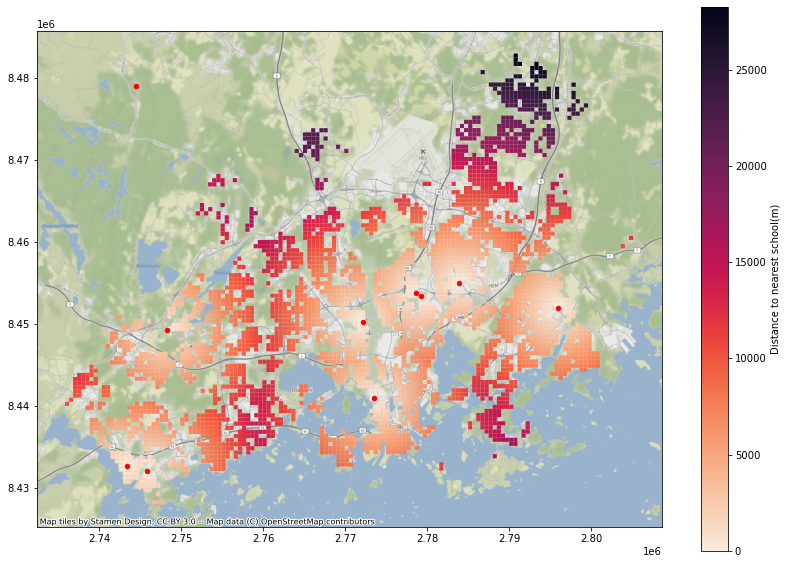

In [114]:
# Creating the figure
fig, ax = plt.subplots(figsize=(14,10)) 
# Plotting the population grid with darker red values the farther away the nearest school is
# Using a reddish colour palette which shows relatively well (especially the darker colours)
# Also adding a legend
pop.plot(ax=ax, 
         column="dist_sp", 
         cmap=sns.color_palette("rocket_r", as_cmap=True), 
         legend=True,
         legend_kwds={"label":"Distance to nearest school(m)"})
# Adding the schools as red points
special.plot(ax = ax, color="red", markersize=20) 
# Adding a basemap to facilitate identifying the areas of the map
ctx.add_basemap(ax)

The pattern seems to be similar to the cases before, but in the case of "central" Espoo there seems to be need for a special school. Considering that the population of that area is quite high, it would be a good investment that would probably benefit a lot of people.

##### 4. How many kids and teenagers live in the are there in the influence area of each school?

By now, you're probably telling yourself: "But Nico! So far you have been completely disregarding the population density of each area! Maybe the areas with higher distances to the nearest schools are also the least populated." And that is completely right. Now I want to do a last map including to some extent the element of population density and the amount of kids in the grids closest to each school. 

But in question 1 you ignored population density!